## 1. Project Introduction


<summary><strong>Loan Default Predictor: A Machine Learning Approach</strong></summary>

**Goal**: Predict whether a loan application will be approved based on demographic, income, credit history, and other applicant-level features.

**Dataset**: [Loan Prediction Dataset – Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii)

**Tools**: Python, scikit-learn, XGBoost, SHAP, SMOTE

---

The notebook includes:
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Model Building (Logistic Regression, Decision Tree)
- Evaluation and Feature Importance





**2. Import Required Libraries**

In [93]:
# Load essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings("ignore")


**3. Upload and Load Dataset**

In [94]:
# For local Colab file upload
from google.colab import files
uploaded = files.upload()

# Then load the CSV
import pandas as pd

df = pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
print("Data loaded. Shape:", df.shape)
df.head()


Saving train_u6lujuX_CVtuZ9i.csv to train_u6lujuX_CVtuZ9i (4).csv
Data loaded. Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


**4. Exploratory Data Analysis**

In [95]:
# Basic structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [96]:
# Check for missing values in each column
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing

,0
Credit_History,50
Self_Employed,32
LoanAmount,22
Dependents,15
Loan_Amount_Term,14
Gender,13
Married,3


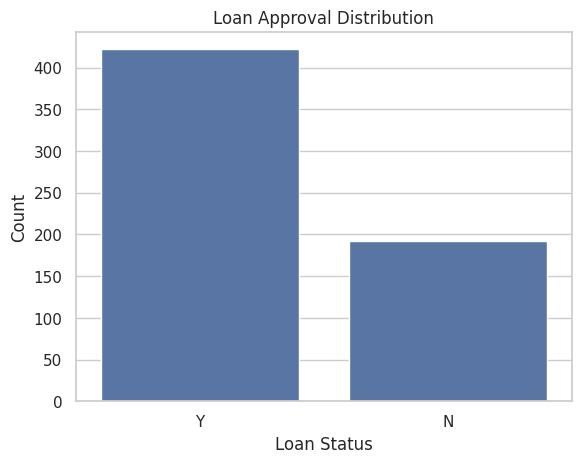

Loan Approval Rates (%):
Loan_Status
Y    68.73%
N    31.27%
Name: proportion, dtype: object


In [97]:
# Check balance of the target class
sns.countplot(data=df, x='Loan_Status')
plt.title('Loan Approval Distribution')
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

# Show value counts as numbers
loan_status_percent = df['Loan_Status'].value_counts(normalize=True) * 100
print("Loan Approval Rates (%):")
print(loan_status_percent.apply(lambda x: f"{x:.2f}%"))

# Loan Status Distribution
#The bar chart shows the distribution of  `Loan_Status`, where:
 #- `Y` indicates the loan was approved
 #- `N` indicates the loan was not approved

# Observations:
 #- Approximately 69% of applicants were approved
 #- About **31%** were denied
 #- There is a moderate class imbalance, with approvals being more frequent


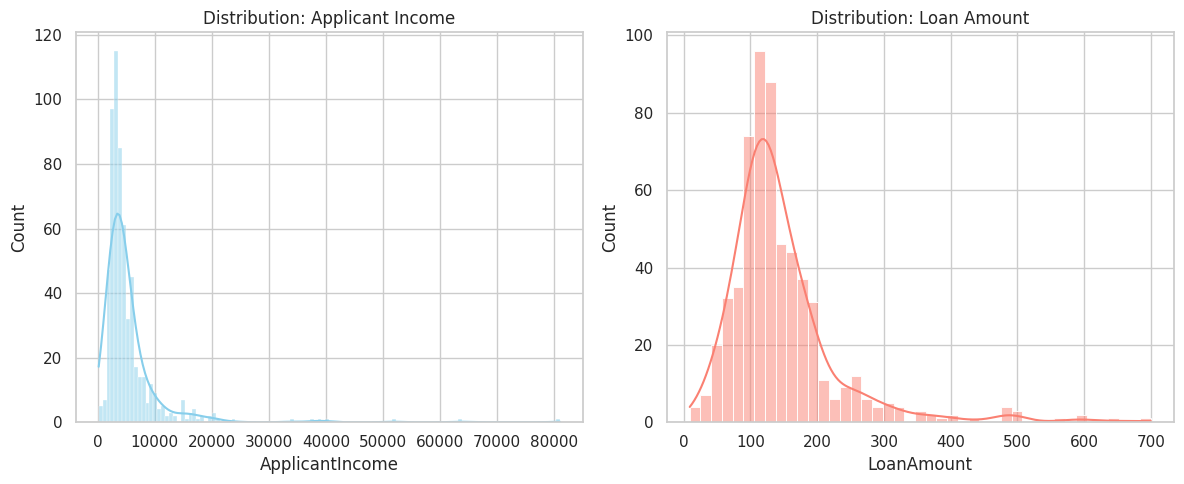

In [98]:
#  Histogram of Applicant Income and Loan Amount
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['ApplicantIncome'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribution: Applicant Income")

sns.histplot(df['LoanAmount'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Distribution: Loan Amount")

plt.tight_layout()
plt.show()

# Applicant Income & Loan Amount Distributions
#The histograms  illustrate the distribution of two key numeric features in the dataset:


#Applicant Income:
 #- Highly right-skewed with a long tail.
 #- Majority of applicants earn below 10,000, but a few high-income outliers stretch the distribution.

# Loan Amount:
 #- Also right-skewed, with most loans clustered between 100,000 to 200,000.
 #- Some larger loan applications exist, but they are infrequent.

# Implication:
#Understanding the spread and skewness of numerical variables helps in:
 #- Deciding preprocessing steps like scaling or transformations.
 #- Preventing models from being biased due to outliers.
 #- Revealing feature interactions that may explain loan approval outcomes.


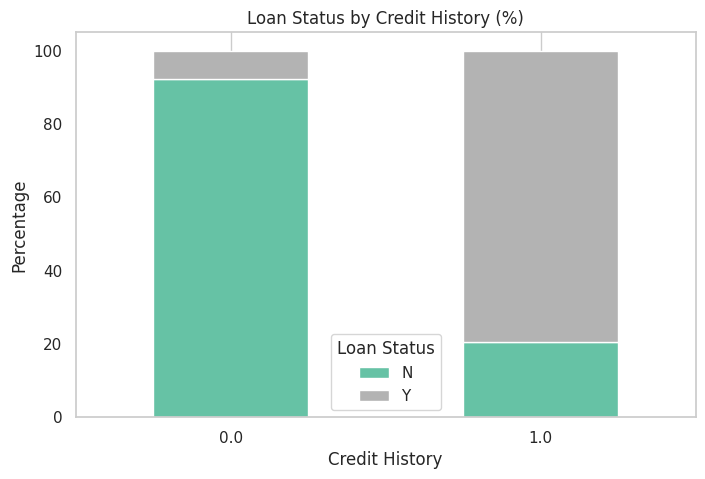

In [99]:
#STEP Loan status by credit history
credit_plot = pd.crosstab(df['Credit_History'], df['Loan_Status'], normalize='index') * 100
credit_plot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')

plt.title('Loan Status by Credit History (%)')
plt.ylabel('Percentage')
plt.xlabel('Credit History')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

#Loan Status by Credit History (%)
#The stacked bar chart shows the percentage distribution of loan approvals (`Loan_Status`) across different values of `Credit_History`:
 #- `1.0` = Good credit history (meets lending criteria)
 #- `0.0` = Poor or no credit history

# Insights:
 #- Applicants with a credit history (`1.0`) have a much higher loan approval rate — approximately 80% of them were approved.
 #- In contrast, most applicants without a credit history (`0.0`) were denied.
 #- This indicates that Credit History is a strong predictor of loan approval.


# Implications:
 #- This relationship is expected — lenders rely heavily on credit scores/history to assess risk.
 #- Missing or poor credit records may trigger rejection, regardless of income or employment status.



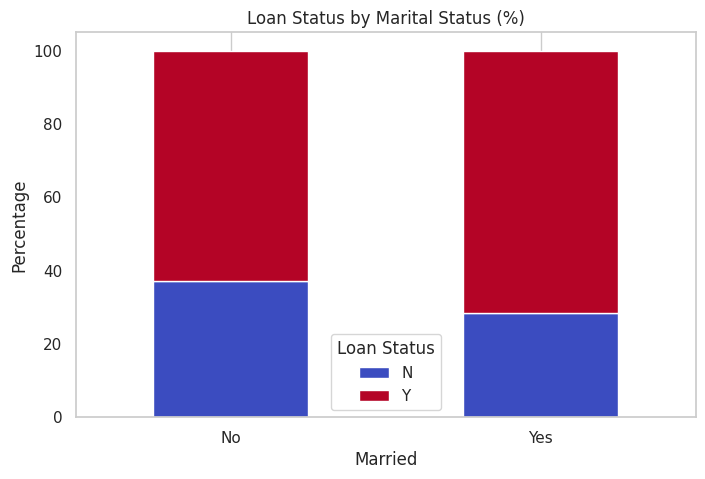

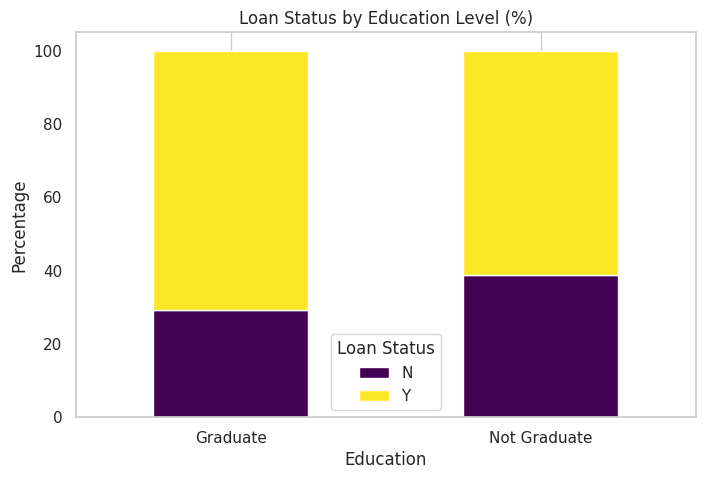

In [100]:
# Married vs Loan Approval
married_plot = pd.crosstab(df['Married'], df['Loan_Status'], normalize='index') * 100
married_plot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='coolwarm')

plt.title('Loan Status by Marital Status (%)')
plt.ylabel('Percentage')
plt.xlabel('Married')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Education vs Loan Approval
edu_plot = pd.crosstab(df['Education'], df['Loan_Status'], normalize='index') * 100
edu_plot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')

plt.title('Loan Status by Education Level (%)')
plt.ylabel('Percentage')
plt.xlabel('Education')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


#Loan Status by Marital Status and Education (%)
#The stacked bar plots  show the percentage of loan approvals (`Loan_Status = Y`) and rejections (`Loan_Status = N`) grouped by:
#- Marital Status (`Married`)
#- Education Level (`Education`)

# Loan Status by Marital Status:
 #- Both married and unmarried applicants show a similar approval pattern.
 #- However, married applicants have a slightly higher loan approval rate.


# Loan Status by Education:
 #- Graduates have slightly lower rejection rates compared to non-graduates.
 #- Still, the difference is marginal — education does not appear to be a dominant factor in loan approval compared to credit history.



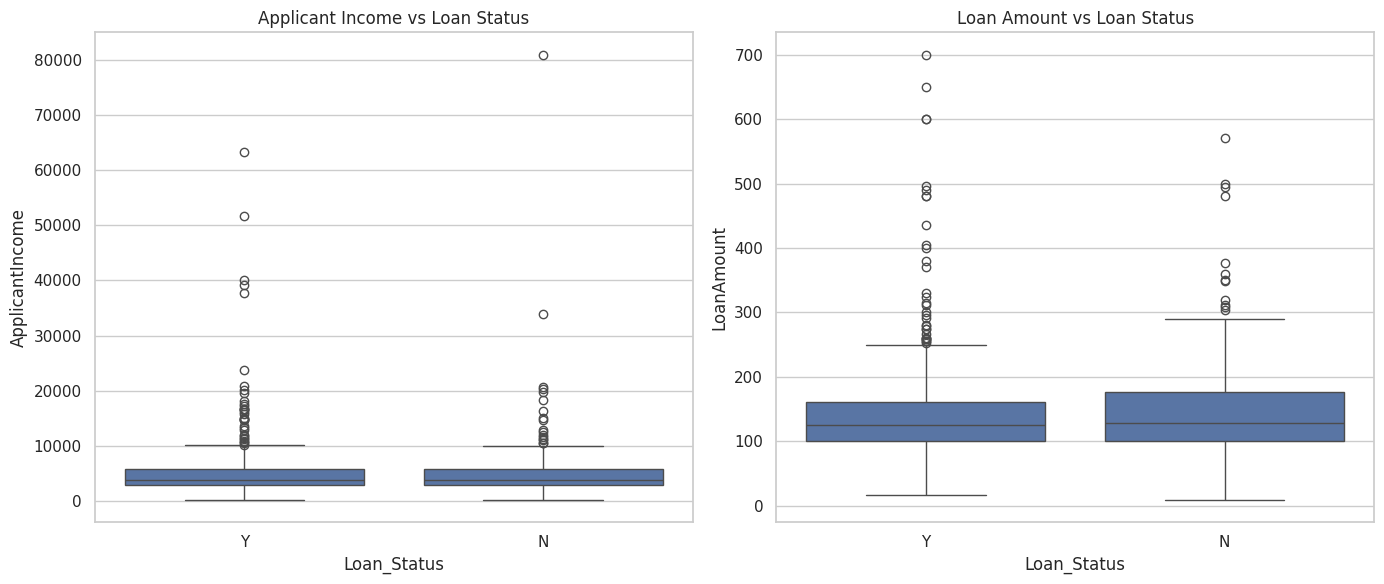

In [101]:
# Income and Loan Amount by approval status
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df, ax=axes[0])
axes[0].set_title('Applicant Income vs Loan Status')

sns.boxplot(x='Loan_Status', y='LoanAmount', data=df, ax=axes[1])
axes[1].set_title('Loan Amount vs Loan Status')

plt.tight_layout()
plt.show()

# Applicant Income & Loan Amount by Loan Status
# The boxplots show how the numerical features `ApplicantIncome` and `LoanAmount` vary across loan approval outcomes (`Loan_Status`).

#Applicant Income:
 #- The median income is fairly similar for both approved (`Y`) and denied (`N`) applicants.
 #- However, there's a larger number of outliers in the approved group, indicating that some high-income applicants did get approved.
 #- Despite high variance, income alone does not guarantee approval.

# Loan Amount:
 #- The **distribution of loan amounts is almost identical** between approved and denied applications.
 #- This suggests that Loan Amount by itself is not a strong discriminator for loan approval.



**5. Data Preprocessing**

In [102]:
##Impute missing values

# Numerical features: use median or mode based on skewness
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Categorical features: fill with most frequent (mode)
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [103]:
#Feature Engineering

# Total income of applicant and co-applicant
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# EMI = LoanAmount / Loan_Amount_Term
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']

# Balance income after paying EMI (in '000s)
df['Balance_Income'] = df['Total_Income'] - (df['EMI'] * 1000)

In [104]:
#Drop ID column (non-predictive)
df.drop('Loan_ID', axis=1, inplace=True)

**6. Model Building**

In [105]:
#Encode categorical variables using Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [106]:
#Split data into features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

print(" Features shape:", X.shape)
print(" Target shape:", y.shape)

 Features shape: (614, 14)
 Target shape: (614,)


In [107]:
#Train-Test Split (75/25)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(" X_train:", X_train.shape)
print(" X_test:", X_test.shape)
print(" y_train distribution:\n", y_train.value_counts(normalize=True))


 X_train: (460, 14)
 X_test: (154, 14)
 y_train distribution:
 Loan_Status
1    0.686957
0    0.313043
Name: proportion, dtype: float64


In [108]:
#Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

In [109]:
#Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)  # limit depth to avoid overfitting
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test)

**7. Model Evaluation**

In [110]:
#Evaluate both models
from sklearn.metrics import classification_report, confusion_matrix

print(" Logistic Regression Performance")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

print("\n Decision Tree Performance")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

 Logistic Regression Performance
[[ 20  28]
 [  2 104]]
              precision    recall  f1-score   support

           0       0.91      0.42      0.57        48
           1       0.79      0.98      0.87       106

    accuracy                           0.81       154
   macro avg       0.85      0.70      0.72       154
weighted avg       0.83      0.81      0.78       154


 Decision Tree Performance
[[ 27  21]
 [  4 102]]
              precision    recall  f1-score   support

           0       0.87      0.56      0.68        48
           1       0.83      0.96      0.89       106

    accuracy                           0.84       154
   macro avg       0.85      0.76      0.79       154
weighted avg       0.84      0.84      0.83       154



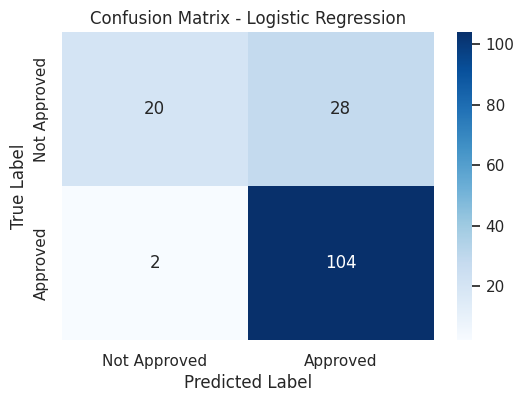

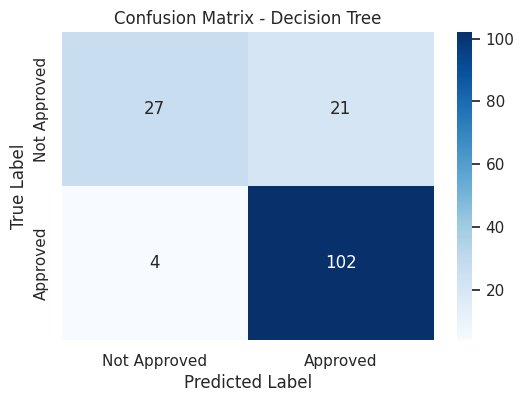

In [111]:
def plot_confusion_matrix(cm, model_name, classes=['Not Approved', 'Approved']):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrices
plot_confusion_matrix(cm_lr, "Logistic Regression")
plot_confusion_matrix(cm_dt, "Decision Tree")

# Confusion Matrix – Logistic Regression vs Decision Tree

The confusion matrices above show how well each model predicted loan approval (`Loan_Status`) on the test dataset:

---

# Logistic Regression
- **True Positives (Approved & Predicted Approved)**: 104  
- **True Negatives (Not Approved & Predicted Not Approved)**: 20  
- **False Positives (Predicted Approved, Actually Not Approved)**: 28  
- **False Negatives (Predicted Not Approved, Actually Approved)**: 2

**Key Insight**:  
- Very few false negatives (only 2), meaning the model rarely misses approved applications.
- However, it incorrectly approves many who should be denied, which may pose a financial risk.


---

#### Decision Tree Classifier
- **True Positives**: 102  
- **True Negatives**: 27  
- **False Positives**: 21  
- **False Negatives**: 4

**Key Insight**:  
- The Decision Tree offers a more balanced performance between correctly identifying approvals and rejections.
- Slightly better at correctly rejecting ineligible applicants (higher TN), but slightly worse at catching all approved ones

---

### Takeaway:
- **Logistic Regression** is highly sensitive to true approvals (high recall for approved), making it ideal if **minimizing rejections of eligible applicants** is critical.
- **Decision Tree** provides more **balanced classification** with better handling of rejections.




**8. ROC Curve and AUC**

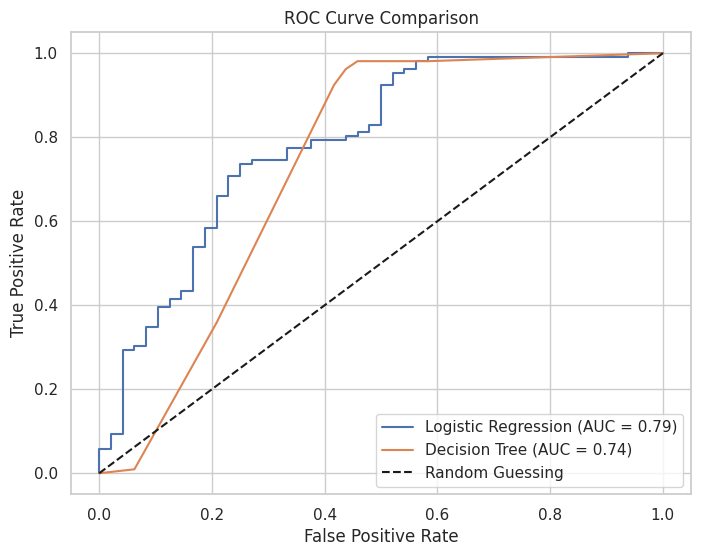

In [112]:
 #ROC Curve for both models
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for ROC
lr_probs = lr_model.predict_proba(X_test)[:, 1]
dt_probs = dt_model.predict_proba(X_test)[:, 1]

# Get ROC curve points
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)

# AUC scores
auc_lr = roc_auc_score(y_test, lr_probs)
auc_dt = roc_auc_score(y_test, dt_probs)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

### ROC Curve – Logistic Regression vs Decision Tree

The ROC (Receiver Operating Characteristic) curve illustrates the trade-off between **True Positive Rate (Recall)** and **False Positive Rate** for different classification thresholds.

---

### AUC Scores:
- **Logistic Regression**: AUC = 0.79
- **Decision Tree**: AUC = 0.74
- **Baseline (Random Guessing)**: AUC = 0.50

---

### Interpretation:
- The Logistic Regression clearly outperforms Decision Tree, achieving a higher AUC (0.79 vs 0.74).
- This means the Decision Tree is better at distinguishing between approved and non-approved applicants across all thresholds.


---

### Implication:
- AUC is a threshold-independent metric, useful when comparing models across various operating conditions.
- Since loan decisions are sensitive to recall and false positives, AUC helps in selecting the model with better general separation power.



**9. Feature Importance**

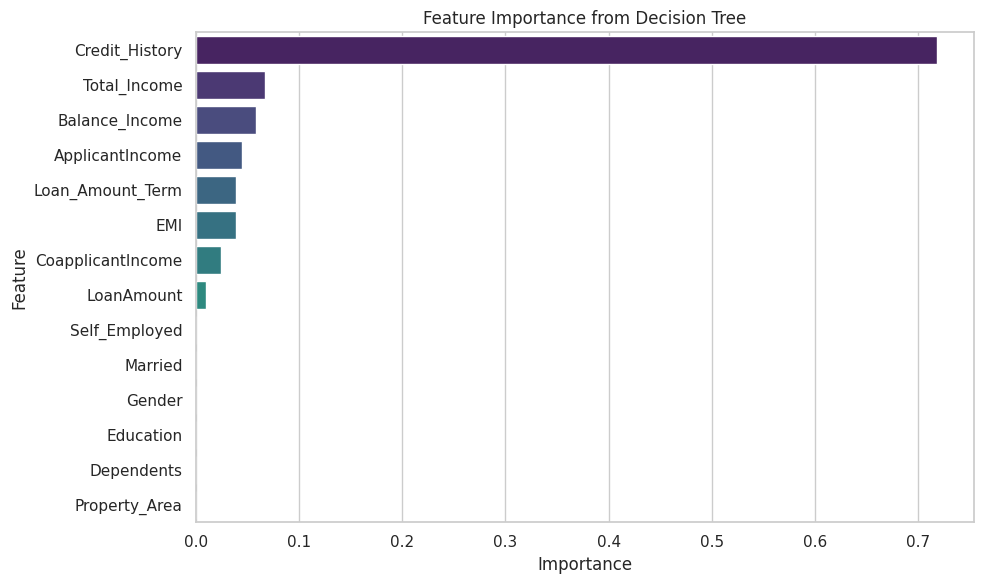

In [113]:
 #Plot Feature Importance (Decision Tree)
importances = dt_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance from Decision Tree")
plt.tight_layout()
plt.show()

### Feature Importance from Decision Tree

The bar chart above shows the top features used by the Decision Tree model to predict `Loan_Status`.

Each bar represents a feature's relative importance based on how often and effectively it was used to split decision nodes in the tree.

---

### Top Influential Features:

1. **Credit_History**:
   - Dominates the model with ~70% relative importance.
   - This confirms earlier visual insights — credit history is the strongest indicator of loan approval.

2. **Total_Income**:
   - Important for evaluating repayment capacity.
   - Combines both applicant and co-applicant income for a more holistic view.

3. **Balance_Income**
   - Income remaining after EMI deductions.
   - Helps assess whether the applicant has financial breathing room.

4. **ApplicantIncome**, **Loan_Amount_Term**, **EMI**
   - Supportive numeric features capturing financial strength and loan structure.

---

### Lesser Impact Features:
- **LoanAmount**, **Self_Employed**, **Married**, **Gender**, and **Property_Area** show **minimal influence** on the model.
- These may not be highly discriminative or may be correlated with more powerful features like income or credit history.

---

### Interpretation:
- The model is heavily*credit-risk driven, with secondary consideration for income and repayment structure.
- Variables like marital status or education, though important socially, have little predictive value for loan decisions in this dataset.


